# fmdtools-AdaStress integration

This goal of this notebook is to illustrate running Adaptive Stress Testing on fmdtools model using the AdaStress package.

For this setup to work, first install:
- AdaStress (and related packages) in Julia
- fmdtools (and related packages) in Python
- PyCall in Julia
- PyJulia in Python

In [1]:
using Plots
using AdaStress

### Python setup:

First, we get the fmdtools model from its respective folder

In [2]:
using PyCall
#ENV["MPLBACKEND"]="qt5agg"
using PyPlot
py"""
import sys, os
sys.path.insert(0,os.curdir)
sys.path.insert(1,os.path.join('..'))
"""

In [3]:
#pygui_start(:qt)
#PyCall.fixqtpath()

Next, we get the module--in this case we will be using the stochastic pump model in `/example_pump/pump_stochastic`

In [4]:
pump_module = pyimport("pump_stochastic")
pump_model = pump_module.Pump()

PyObject Pump model at 0x1ae02e0 
functions: 
- ImportEE:({'mode': 'nom', 'effstate': 1.0, 'grid_noise': 1.0}, {'nom'}) 
- ImportWater:({'mode': 'nom'}, {'nom'}) 
- ImportSignal:({'mode': 'nom', 'sig_noise': 1.0}, {'nom'}) 
- MoveWater:({'total_flow': 0.0, 'mode': 'nom', 'eff': 1.0}, {'nom'}) 
- ExportWater:({'mode': 'nom'}, {'nom'}) 
flows: 
- EE_1:{'current': 1.0, 'voltage': 1.0}
- Sig_1:{'power': 1.0}
- Wat_1:{'flowrate': 1.0, 'pressure': 1.0, 'area': 1.0, 'level': 1.0}
- Wat_2:{'flowrate': 1.0, 'pressure': 1.0, 'area': 1.0, 'level': 1.0}


To get the propagation/analysis methods, we can further import the fmdtools packages...

In [5]:
prop = pyimport("faultsim.propagate")
rd = pyimport("resultdisp")

PyObject <module 'resultdisp' from 'C:\\Users\\dhulse\\Documents\\GitHub\\fmdtools\\fmdtools\\resultdisp\\__init__.py'>

Example simulation

In [6]:
endresult, mdlhist = prop.nominal(pump_model, run_stochastic=true);

In [7]:
fxnflows = Dict("MoveWater"=>["eff","total_flow"], "Wat_2"=>["flowrate","pressure"])

Dict{String, Vector{String}} with 2 entries:
  "MoveWater" => ["eff", "total_flow"]
  "Wat_2"     => ["flowrate", "pressure"]

Visualizing metrics over time...

NOTE: in order for `rd.plot.mdlhists` to work correctly, make sure to use the `Using PyCall` command at the beginning.

fig, axs = rd.plot.mdlhists(mdlhist, fxnflowvals=fxnflows)

## AdaStress Setup

Interfacing AdaStress with fmdtools models is enabled by the `DynamicProblem` class in `faultsim.search` (though this can also be done manually). See below. 

In [8]:
search = pyimport("faultsim.search")
DynamicProblem = search.DynamicInterface

PyObject <class 'faultsim.search.DynamicInterface'>

In [9]:
prob = DynamicProblem(pump_model)

PyObject <faultsim.search.DynamicInterface object at 0x0000000068E40C70>

Defining the simulation is quite simple with the DynamicProblem class. Note the possible options from this class

In [10]:
?DynamicProblem.__init__


        Initializing the problem

        Parameters
        ----------
        mdl : Model
            Model defining the simulation.
        paramdict : dict, optional
            Parameters to run the model at. The default is {}.
        t_max : float, optional
            Maximum simulation time. The default is False.
        track : str/dict, optional
            Properties of the model to track over time. The default is "all".
        run_stochastic : bool/str, optional
            Whether to run stochastic behaviors (True/False) and/or return pdf "track_pdf". The default is "track_pdf".
        desired_result : list, optional
            List of desired results to return at each update. The default is [].
        use_end_condition : bool, optional
            Whether to use model end-condition. The default is None.
        

In [11]:
Base.@kwdef mutable struct PumpSim <: AdaStress.BlackBox
    sim::PyObject = DynamicProblem(pump_model)
end

PumpSim

In [12]:
function initialize!(sim::PumpSim)
    sim.sim = DynamicProblem(pump_model)
end

initialize! (generic function with 1 method)

Updating is further enabled by DynamicProblem.update

In [13]:
?DynamicProblem.update


        Updates the model states at the simulation time and iterates time

        Parameters
        ----------
        seed : seed, optional
            Seed for the simulation. The default is {}.
        faults : dict, optional
            faults to inject in the model, with structure {fxn:[faults]}. The default is {}.
        disturbances : dict, optional
            Variables to change in the model, with structure {fxn.var:value}. The default is {}.

        Returns
        -------
        returns : dict
            dictionary of returns with values corresponding to desired_result
        

In [14]:
function update!(sim::PumpSim)
    seed = rand(0:1_000_000_000)
    returns = sim.sim.update(seed=seed)
    return log(returns["pdf"]) # note: needs to return a probability from somewhere - needs to be a log pdf?
end

update! (generic function with 1 method)

Model end-states can be interfaced with using `DynamicProblem.check_sim_end`, which additionally accomodates external conditions.

In [15]:
function isterminal!(sim::PumpSim)
    has_faults = sim.sim.mdl.fxns["MoveWater"].any_faults() # our external condition
    terminal = sim.sim.check_sim_end(external_condition=has_faults)
    return terminal
end

isterminal! (generic function with 1 method)

In [16]:
function isevent!(sim::PumpSim)
    faults = sim.sim.mdl.fxns["MoveWater"].any_faults() 
    return faults
end

isevent! (generic function with 1 method)

Finally, the below shows the full setup:

In [17]:
AdaStress.reset!(sim::PumpSim) = initialize!(sim)
AdaStress.step!(sim::PumpSim) = update!(sim)
AdaStress.isterminal(sim::PumpSim) = isterminal!(sim)
AdaStress.isevent(sim::PumpSim) = isevent!(sim)     # difficult: get pressure > 15 ten times
# AdaStress.isevent(sim::PumpSim) = 15.0-sim.mdl.flows["Wat_1"].pressure <= 0 # - easy: just get pressure > 15 (once!)
#AdaStress.distance(sim::PumpSim) = 15.0-sim.mdl.flows["Wat_1"].pressure
AdaStress.distance(sim::PumpSim) = float(sum(sim.sim.log["flows"]["Wat_1"]["pressure"].<=15))

### Running AdaStress Methods

Monte Carlo Search

In [18]:
mcs = AdaStress.Solvers.MCS(num_iterations=10_00)

AdaStress.Solvers.MonteCarloSearch.MCS(1000, 10)

In [19]:
mdp = AdaStress.ASTMDP(PumpSim())
mdp.reward.event_bonus = 200.0

200.0

In [20]:
using Random

In [21]:
Random.seed!(0)
sol = mcs(() -> mdp)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:48mmm


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  MCSResult(UInt32[0x533c9304, 0x88904ca3, 0x33c0db12, 0xd905012e, 0… => 121.165
  MCSResult(UInt32[0xd47d4ad4, 0xa4a2a569, 0x5a54294c, 0x745fca30, 0… => 121.265
  MCSResult(UInt32[0xaa008a74, 0x25e12b2b, 0xd0fc1988, 0xfd7b5ec0, 0… => 121.462
  MCSResult(UInt32[0x939468f7, 0x4fd6ca1d, 0xc4ad4f55, 0x7596eb71, 0… => 122.885
  MCSResult(UInt32[0x83aad7ca, 0x59cc490b, 0x522b0be1, 0x9c17b384, 0… => 122.94
  MCSResult(UInt32[0x856cd12e, 0x900be46e, 0x9481cb6e, 0x326ee66b, 0… => 123.619
  MCSResult(UInt32[0x679b5373, 0x7c7da679, 0x0551ccc1, 0x8f082a3c, 0… => 124.505
  MCSResult(UInt32[0x345ef935, 0x6e2625e6, 0x4d37b4f4, 0xfb5aa2c9, 0… => 124.776
  MCSResult(UInt32[0x3a4111cf, 0x2c47e3cd, 0xf0efd46f, 0x34283933, 0… => 125.586
  MCSResult(UInt32[0x6a7aafcb, 0xafe1b494, 0x1e8c0ab1, 0xb72598df, 0… => 288.856

In [22]:
i=0
mdlhists = Dict()
for (result, r) in sol
    AdaStress.replay!(mdp, result)
    mdlhists[i] = mdp.sim.sim.log
    i+=1
end

In [23]:
fxnflows2 = Dict("MoveWater"=>["eff","total_flow"], "Wat_2"=>["flowrate","pressure"])

Dict{String, Vector{String}} with 2 entries:
  "MoveWater" => ["eff", "total_flow"]
  "Wat_2"     => ["flowrate", "pressure"]

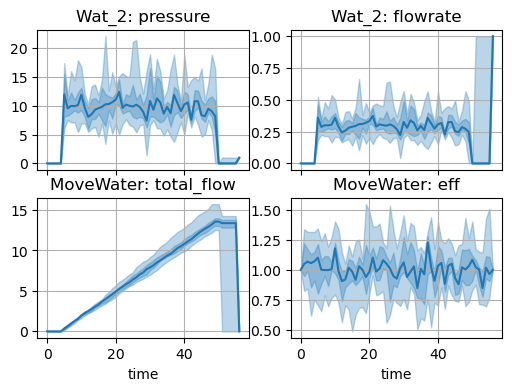

(Figure(PyObject <Figure size 600x400 with 4 Axes>), PyObject[PyObject <AxesSubplot:title={'center':'Wat_2: pressure'}>, PyObject <AxesSubplot:title={'center':'Wat_2: flowrate'}>, PyObject <AxesSubplot:title={'center':'MoveWater: total_flow'}, xlabel='time'>, PyObject <AxesSubplot:title={'center':'MoveWater: eff'}, xlabel='time'>])

In [24]:
rd.plot.mdlhists(mdlhists, fxnflowvals=fxnflows2, aggregation="percentile")

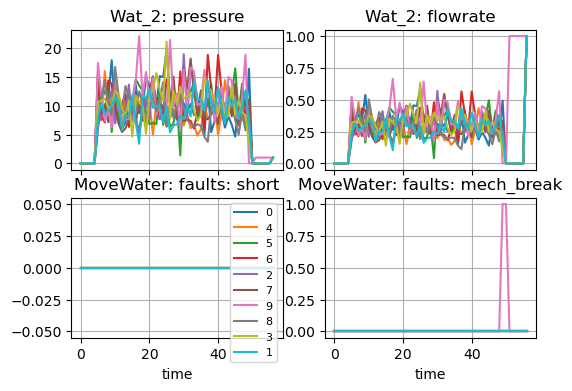

(Figure(PyObject <Figure size 600x400 with 4 Axes>), PyObject[PyObject <AxesSubplot:title={'center':'Wat_2: pressure'}>, PyObject <AxesSubplot:title={'center':'Wat_2: flowrate'}>, PyObject <AxesSubplot:title={'center':'MoveWater: faults: short'}, xlabel='time'>, PyObject <AxesSubplot:title={'center':'MoveWater: faults: mech_break'}, xlabel='time'>])

In [25]:
fxnflows = Dict("MoveWater"=>["pressure","faults"], "Wat_2"=>["flowrate","pressure"])
rd.plot.mdlhists(mdlhists, fxnflowvals=fxnflows, legend_loc=2)

### MCTS

Monte Carlo Tree Search

In [28]:
mcts = AdaStress.Solvers.MCTS(num_iterations=1000)

AdaStress.Solvers.MonteCarloTreeSearch.MCTS(1000, 10, 1.0, 0.7, 1.0, nothing)

In [29]:
Random.seed!(0)
@time sol = mcts(() -> mdp)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


113.442056 seconds (176.37 M allocations: 7.913 GiB, 2.99% gc time, 0.02% compilation time)


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  MCTSResult(UInt32[0xf2f16c22, 0xb7d2c17d, 0x17c321e0, 0x4522ee6c, … => 121.215
  MCTSResult(UInt32[0x419dea2c, 0xa4a2a569, 0x5a54294c, 0x745fca30, … => 121.265
  MCTSResult(UInt32[0xd52d4423, 0x9569dcd8, 0xdfb53527, 0xa3b2a596, … => 121.582
  MCTSResult(UInt32[0x2d821bb3, 0xb3c414a5, 0x11bc16dd, 0x62fbf98c, … => 125.019
  MCTSResult(UInt32[0x17d5e66c, 0x04b06d54, 0x7473de98, 0x03d1a98f, … => 125.603
  MCTSResult(UInt32[0xba03b1cc, 0x4e5c1f6e, 0x64ac4a47, 0x236c618f, … => 128.108
  MCTSResult(UInt32[0x08754edb, 0x411777bd, 0x5ad59a28, 0xfffb946f, … => 128.117
  MCTSResult(UInt32[0x372f6504, 0xfb25b078, 0x9e695f15, 0xec1b0ce1, … => 129.095
  MCTSResult(UInt32[0xf2f16c22, 0x727114cf, 0x4be07ea6, 0x1a3a9b8f, … => 130.084
  MCTSResult(UInt32[0xfed17443, 0xb163078f, 0x3dacaf15, 0x12e2466f, … => 287.136

In [30]:
i=0
mdlhists2 = Dict()
for (result, r) in sol
    AdaStress.replay!(mdp, result)
    mdlhists2[i] = mdp.sim.sim.log
    i+=1
end

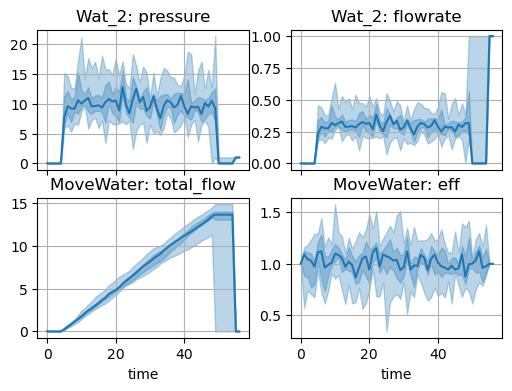

(Figure(PyObject <Figure size 600x400 with 4 Axes>), PyObject[PyObject <AxesSubplot:title={'center':'Wat_2: pressure'}>, PyObject <AxesSubplot:title={'center':'Wat_2: flowrate'}>, PyObject <AxesSubplot:title={'center':'MoveWater: total_flow'}, xlabel='time'>, PyObject <AxesSubplot:title={'center':'MoveWater: eff'}, xlabel='time'>])

In [31]:
rd.plot.mdlhists(mdlhists2, fxnflowvals=fxnflows2, aggregation="percentile")

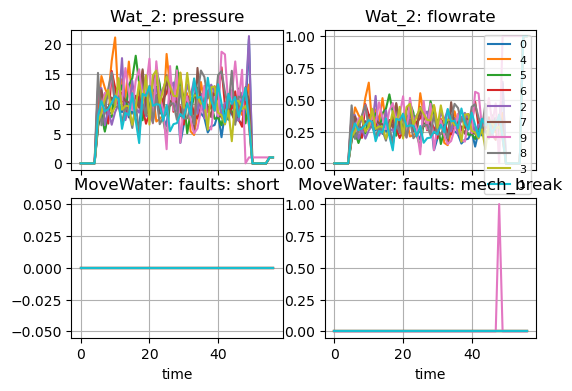

(Figure(PyObject <Figure size 600x400 with 4 Axes>), PyObject[PyObject <AxesSubplot:title={'center':'Wat_2: pressure'}>, PyObject <AxesSubplot:title={'center':'Wat_2: flowrate'}>, PyObject <AxesSubplot:title={'center':'MoveWater: faults: short'}, xlabel='time'>, PyObject <AxesSubplot:title={'center':'MoveWater: faults: mech_break'}, xlabel='time'>])

In [32]:
fxnflows = Dict("MoveWater"=>["pressure","faults"], "Wat_2"=>["flowrate","pressure"])
rd.plot.mdlhists(mdlhists2, fxnflowvals=fxnflows, legend_loc=1)

As we can see, MCTS finds more breakage faults (8 instead of 3), as a result of being a more informed search method.

## Grey Box Methods

As opposed to black box methods, which share no information about the system state with the agent, grey box methods let the agent sample the random distributions and pass disturbances to the model directly, rather than just passing seeds.

Implementation is based off of: https://github.com/NASA-SW-VnV/AdaStress.jl/blob/master/examples/walk2d/walk2d.ipynb

In [33]:
using AdaStress
import AdaStress.GrayBox
using Distributions
using Random

### Pump

To use the gray box method, we have to first define which variables in the model to sample/update. fmdtools models have two types of random states:
- general random states, which are updated in the behavioral method (whose distributions thus cannot be accessed without looking at the code)
- auto-updating random states, which are updated from a given distribution defined with auto_update=(dist,params). These distributions can be accessed directly from the model.

Both can be queried in AdaStress, but using different methods. In general, however, using a Gray Box method means that *all* stochastic behavior (desired by the analysis) should be represented in AdaStress/Julia, since integration relies on running the model as deterministic.

Below are the random states of the model:

In [34]:
rand_states = pump_model.get_rand_states()

Dict{Any, Any} with 3 entries:
  "ImportSignal" => Dict{Any, Any}("sig_noise"=>(1.0, nothing, nothing, 9540584…
  "MoveWater"    => Dict{Any, Any}("eff"=>(1.0, "normal", (1.0, 0.2), 192379353…
  "ImportEE"     => Dict{Any, Any}("effstate"=>(1.0, nothing, nothing, 56058474…

As well as the auto-updating random states:

In [35]:
rand_states = pump_model.get_rand_states(auto_update_only=true)

Dict{Any, Any} with 1 entry:
  "MoveWater" => Dict{Any, Any}("eff"=>(1.0, "normal", (1.0, 0.2), 1923793530))

Because of the different methods that julia/AdaStress uses to sample random distributions, these distributions need to be re-implemented in julia. In this example we do this for the eff parameter in MoveWater.

Below we create a `Pump` struct, and define random disturbances which will affect the model.

In [36]:
#define distributions for the model
#Base.@kwdef mutable struct Init_Rand_Params
#    eff::Distribution = Normal(1.0, 0.2)
#end
#Base.@kwdef mutable struct Pump
#    t::Float64=0.0
#    t_max::Float64=last(pump_model.times)
#    t_ind::Int=0
#    mdl::PyObject = pump_model
#end
#function initialize(pump::Pump, init::Init_Rand_Params)
#    pump.mdl = pump.mdl.__class__()
#    pump.mdl.fxns["MoveWater"].eff = rand(init.eff)
#end

#function update(pump::Pump, eff::Float64)
#    pump.mdl.fxns["MoveWater"].eff = eff
#end

Disturbance and failure models

In [37]:
#Base.@kwdef mutable struct Disturbance
#    eff::Distribution = Normal(1.0, 0.2)
#end

System under test: okay to remove, often refers to policy that we are trying to test within the system dynamics

In [38]:
#mutable struct SystemUnderTest
#    eff::Float64
#end
#update(pump::Pump, sut::SystemUnderTest) = update(pump, sut.eff)

### Simulator
The simulator is roughly the same as the simulation for the black box model except it has an `environment` which samples stochastic variables and then changes parameters in the model. Note that in this case `run_stochastic` is set to `false`, since the variables are being sampled in AdaStress itself (rather than the model).

In [39]:
Base.@kwdef mutable struct Simulator <: AdaStress.GrayBox
    sim::PyObject = DynamicProblem(pump_model)
    env::AdaStress.Environment = AdaStress.Environment()
end

function initialize(sim::Simulator)
    sim.env[:eff] = Normal(1.0, 0.2) #creating  
    sim.sim=DynamicProblem(pump_model, run_stochastic=false)
    return
end

function update!(sim::Simulator, value::AdaStress.EnvironmentValue)
    #sim.mdl.set_values("MoveWater.eff", value[:eff])
    disturbances=Dict("MoveWater.eff"=>value[:eff])
    sim.sim.update(disturbances=disturbances)
    return
end

update! (generic function with 2 methods)

The isterminal and isevent functions will be the same as in the black box model.

In [40]:
function isterminal!(sim::Simulator)
    has_faults = sim.sim.mdl.fxns["MoveWater"].any_faults() # our external condition
    terminal = sim.sim.check_sim_end(external_condition=has_faults)
    return terminal
end
function isevent!(sim::Simulator)
    faults = sim.sim.mdl.fxns["MoveWater"].any_faults() 
    return faults
end

isevent! (generic function with 2 methods)

The interface to adastress is set up below. Of note is the observation interface, which observes `eff` (which is also the action in this simple setup)

In [41]:
Interface.reset!(sim::Simulator) = initialize(sim)

Interface.environment(sim::Simulator) = sim.env

Interface.observe(sim::Simulator) = vcat(sim.sim.mdl.flows["Wat_2"].pressure, sim.sim.t / sim.sim.t_max)

Interface.step!(sim::Simulator, value::AdaStress.EnvironmentValue) = update!(sim, value)

Interface.isterminal(sim::Simulator) = isterminal!(sim)

Interface.isevent(sim::Simulator) = isevent!(sim)

Interface.distance(sim::Simulator) = float(sum([(16-max(min(i,16), 0))^2 for i in sim.sim.log["flows"]["Wat_1"]["pressure"]]))

In [42]:
function mdp_env(; kwargs...)
    mdp = Interface.ASTMDP(Simulator(; kwargs...))
    mdp.reward.event_bonus = 2000.0
    return mdp
end

mdp_env (generic function with 1 method)

Now using the gray box mdp solver:

In [43]:
AdaStress.enable("SoftActorCritic")
using AdaStress.SoftActorCritic

┌ Info: Enabled submodule SoftActorCritic.
└ @ AdaStress C:\Users\dhulse\.julia\packages\AdaStress\RFXZv\src\utils.jl:123


In [44]:
Random.seed!(0)
sac = SAC(;
    obs_dim=2, 
    act_dim=1,
    gamma=0.95,
    act_mins=-1*ones(1),    #number of standard deviations
    act_maxs=10*ones(1),
    hidden_sizes=[30,30,30],
    num_q=2,
    max_buffer_size=1000000,
    batch_size=128,
    epochs=100,
    update_after=0,
    update_every=1,
    steps_per_epoch=54,
    start_steps=100,
    max_ep_len=54,
    num_test_episodes=100,
    displays=[(:fails, mdp -> mdp.sim.sim.mdl.fxns["MoveWater"].has_fault("mech_break") )],
    use_gpu=false
)

SoftActorCritic.ProgressMeter.ijulia_behavior(:clear)
ac, info = sac(mdp_env)

Progress: 100%|█████████████████████████████████████████| Time: 0:05:03
  epoch:  100
  score:  3368.1538
  stdev:  3.8171678
  fails:  1.0


(MLPActorCritic(SoftActorCritic.SquashedGaussianMLPActor(Chain(Dense(2, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu)), Dense(30, 1), Dense(30, 1), Float32[-1.0], Float32[10.0], Random._GLOBAL_RNG(), nothing, false), SoftActorCritic.MLPQFunction[SoftActorCritic.MLPQFunction(Chain(Dense(3, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1))), SoftActorCritic.MLPQFunction(Chain(Dense(3, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1)))]), Dict{String, Any}("score" => Any[3639.3154f0, 3530.497f0, 3672.3123f0, 3822.8728f0, 3862.532f0, 3807.7275f0, 3723.1453f0, 3487.176f0, 3434.0913f0, 3402.7625f0  …  3368.7217f0, 3367.503f0, 3367.4807f0, 3365.4263f0, 3368.8118f0, 3368.653f0, 3370.3752f0, 3366.7698f0, 3368.8843f0, 3368.1538f0], "stdev" => Any[7.968369f0, 45.299828f0, 5.8645067f0, 8.091826f0, 10.341684f0, 11.02232f0, 12.91226f0, 14.24669f0, 11.250485f0, 8.590219f0  …  3.1053045f0, 3.1790936f0, 3.3331904f0, 4.5494237f0, 3.981168f0, 3.603496f0, 4.142967f0

In [45]:
using PyPlot

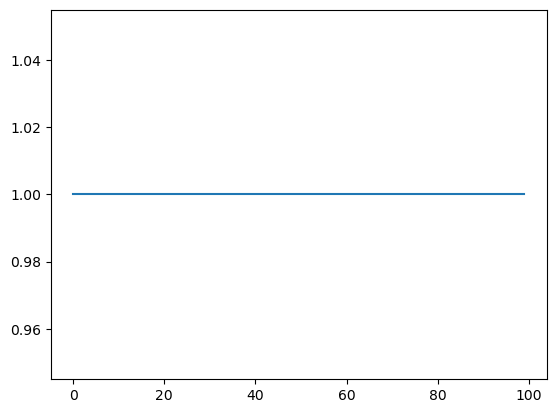

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000062E71220>

In [46]:
plt.plot(info["fails"])

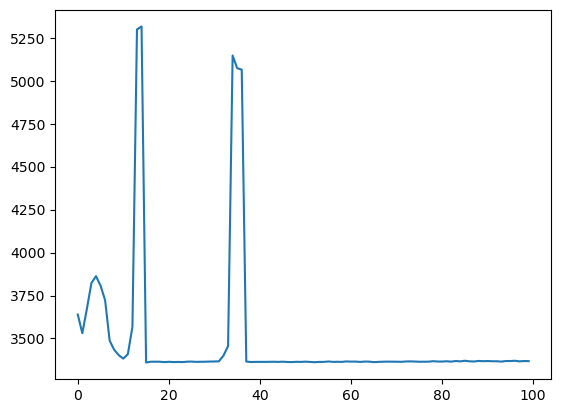

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005B260280>

In [47]:
plt.plot(info["score"])

In [48]:
ac

MLPActorCritic(SoftActorCritic.SquashedGaussianMLPActor(Chain(Dense(2, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu)), Dense(30, 1), Dense(30, 1), Float32[-1.0], Float32[10.0], Random._GLOBAL_RNG(), nothing, false), SoftActorCritic.MLPQFunction[SoftActorCritic.MLPQFunction(Chain(Dense(3, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1))), SoftActorCritic.MLPQFunction(Chain(Dense(3, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1)))])

In [49]:
i=0
mdlhists3 = Dict()
mdp = mdp_env()
for i in 1:100
    a= AdaStress.replay!(mdp, ac)
    mdlhists3[i] = mdp.sim.sim.log
    i+=1
end

In [50]:
a= AdaStress.replay!(mdp, ac)

true

In [51]:
info

Dict{String, Any} with 3 entries:
  "score" => Any[3639.32, 3530.5, 3672.31, 3822.87, 3862.53, 3807.73, 3723.15, …
  "stdev" => Any[7.96837, 45.2998, 5.86451, 8.09183, 10.3417, 11.0223, 12.9123,…
  "fails" => Any[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0,…

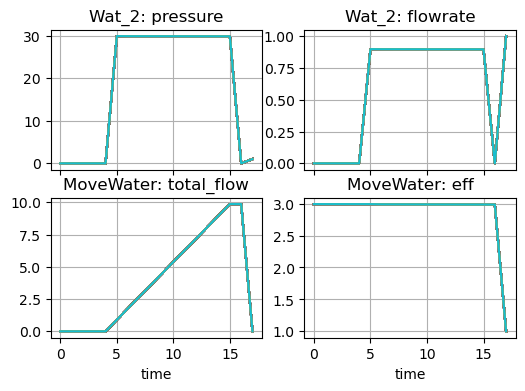

(Figure(PyObject <Figure size 600x400 with 4 Axes>), PyObject[PyObject <AxesSubplot:title={'center':'Wat_2: pressure'}>, PyObject <AxesSubplot:title={'center':'Wat_2: flowrate'}>, PyObject <AxesSubplot:title={'center':'MoveWater: total_flow'}, xlabel='time'>, PyObject <AxesSubplot:title={'center':'MoveWater: eff'}, xlabel='time'>])

In [52]:
fxnflows = Dict("MoveWater"=>["eff","total_flow"], "Wat_2"=>["flowrate","pressure"])
rd.plot.mdlhists(mdlhists3, fxnflowvals=fxnflows, legend_loc=0)

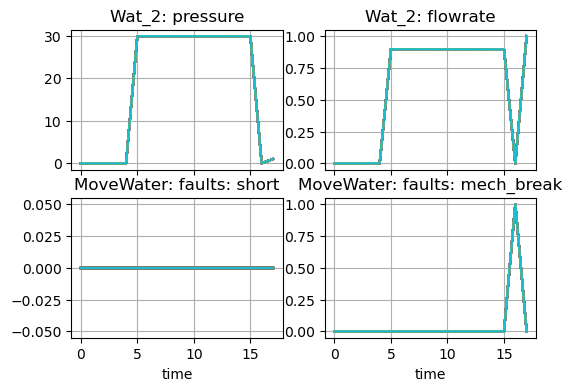

(Figure(PyObject <Figure size 600x400 with 4 Axes>), PyObject[PyObject <AxesSubplot:title={'center':'Wat_2: pressure'}>, PyObject <AxesSubplot:title={'center':'Wat_2: flowrate'}>, PyObject <AxesSubplot:title={'center':'MoveWater: faults: short'}, xlabel='time'>, PyObject <AxesSubplot:title={'center':'MoveWater: faults: mech_break'}, xlabel='time'>])

In [53]:
fxnflows = Dict("MoveWater"=>["pressure","faults"], "Wat_2"=>["flowrate","pressure"])
rd.plot.mdlhists(mdlhists3, fxnflowvals=fxnflows, legend_loc=0)